<a href="https://colab.research.google.com/github/abs711/Data-Analysis/blob/main/Compressed%20image%20recovery/Compressed_Image_Recovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# link Gdrive if using colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
import skimage as ski

import skimage.io
import skimage.transform

import scipy.fftpack as spfft # for discrete cosine transform 

Original size:  (292, 228)
Rescaled size:  (53, 41)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  if __name__ == '__main__':


Text(0.5, 1.0, 'Rescaled image')

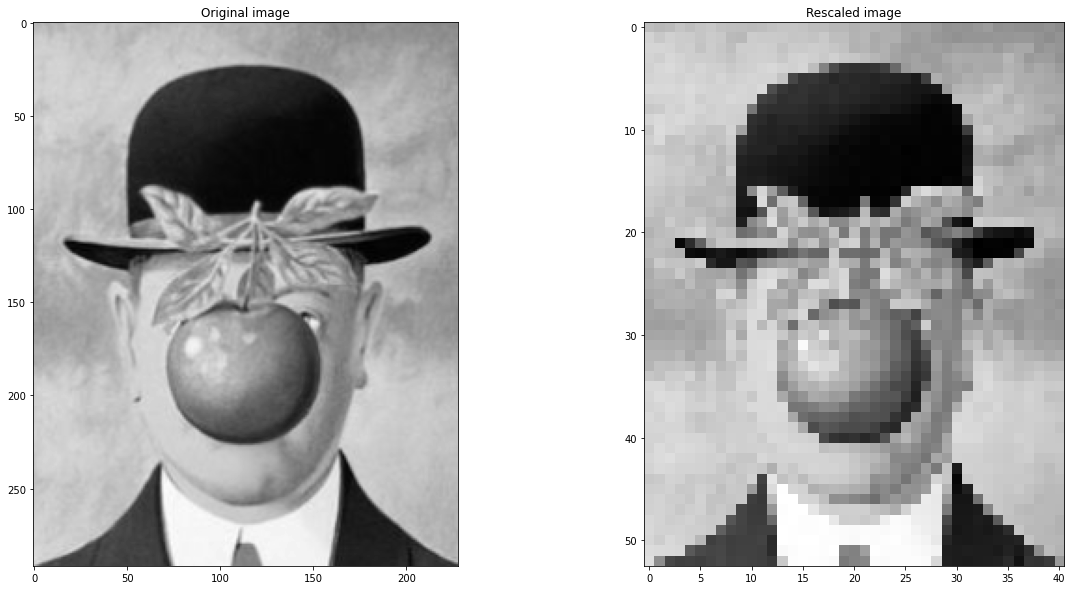

In [ ]:
# import image and rescale 

img_path = '/content/drive/My Drive/AMATH 582/Ass5/SonOfMan.png'

# read image
img_og = ski.io.imread(img_path)

# convert to grayscale and visualize 
img_og = ski.color.rgb2gray(img_og)

fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(img_og, cmap = 'gray')
ax[0].set_title("Original image")

print("Original size: ", img_og.shape)

# resize image 
img = ski.transform.rescale( img_og, 0.18, anti_aliasing=False)

print("Rescaled size: ", img.shape)

ax[1].imshow(img, cmap='gray')
ax[1].set_title("Rescaled image")

In [ ]:
img_og.shape

(292, 228)

In [ ]:
 vec_F = img.flatten()


unflat_img = vec_F.reshape([53,41])

In [ ]:
# constrauct forward and inverse DCT matrices 

# construct DCT matrix
def construct_DCT_Mat( Nx, Ny ):

  # input : Nx number of columns of image 
  #         Ny number of rows of image 

  # output: D DCT matrix mapping image.flatten() to 
  #         DCT(image).flatten()

  Dx = spfft.dct(np.eye(Nx), axis =0, norm='ortho')

  Dy = spfft.dct(np.eye(Ny), axis = 0, norm='ortho')

  D = np.kron(Dy, Dx)

  return D

# construct inverse DCT matrix
def construct_iDCT_Mat( Nx, Ny ):

  # input : Nx number of columns of image 
  #         Ny number of rows of image 

  # output: iD iDCT matrix mapping DCT(image).flatten() to 
  #         image.flatten()

  Dx = spfft.idct(np.eye(Nx), axis =0, norm='ortho')

  Dy = spfft.idct(np.eye(Ny), axis = 0, norm = 'ortho')

  D = np.kron(Dy, Dx)

  return D

Text(0.5, 1.0, 'iDCT_mat')

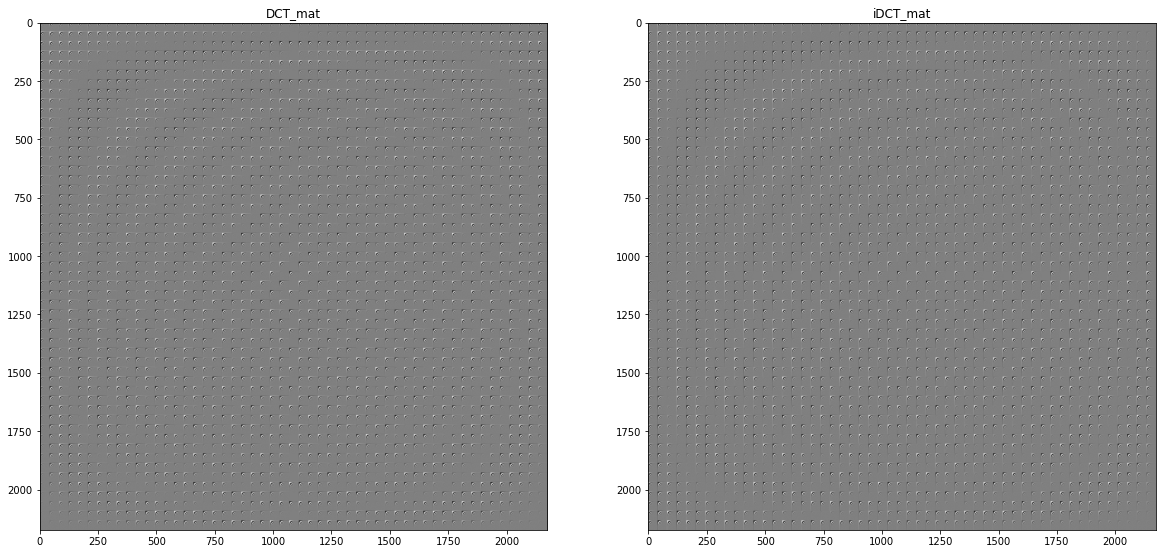

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(D, cmap = 'gray')
ax[0].set_title("DCT_mat")

ax[1].imshow(iD, cmap = 'gray')
ax[1].set_title("iDCT_mat")

In [ ]:
D = construct_DCT_Mat(img.shape[1],img.shape[0])

DCT = np.dot(D,vec_F)

iD = construct_iDCT_Mat(img.shape[1],img.shape[0])

iDCT = np.dot(iD,DCT) # original images

Text(0.5, 1.0, '|coefficients| of the signal')

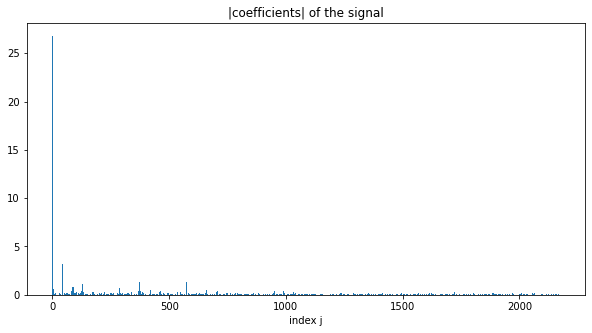

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))

ax.bar(np.arange(len(DCT)), np.abs(DCT))
ax.set_xlabel('index j')
ax.set_title('|coefficients| of the signal')

Text(0.5, 1.0, 'coefficients of the signal')

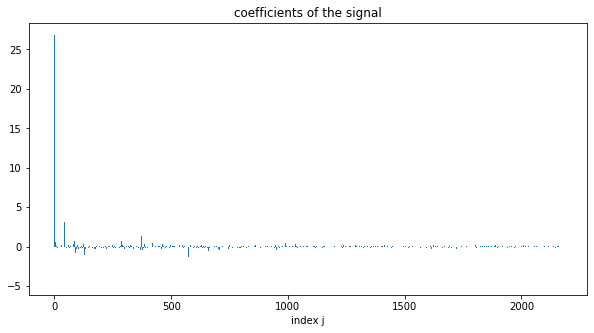

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))

ax.bar(np.arange(len(DCT)), DCT)
ax.set_xlabel('index j')
ax.set_title('coefficients of the signal')

In [ ]:
DCT_sort = np.sort(np.abs(DCT))
arg_sort = np.argsort(np.abs(DCT)) 

In [ ]:
topN = [5,10,20,40]

reconstructions = []

for top_val in topN:
  threshold = DCT_sort[int(2172*(1-top_val/100))]

  compressed_DCT = DCT.copy()

  compressed_DCT[np.abs(compressed_DCT)<threshold] = 0 

  compressed_img = np.dot(iD,compressed_DCT)

  compressed_img = compressed_img.reshape([53,41])

  reconstructions.append(compressed_img)

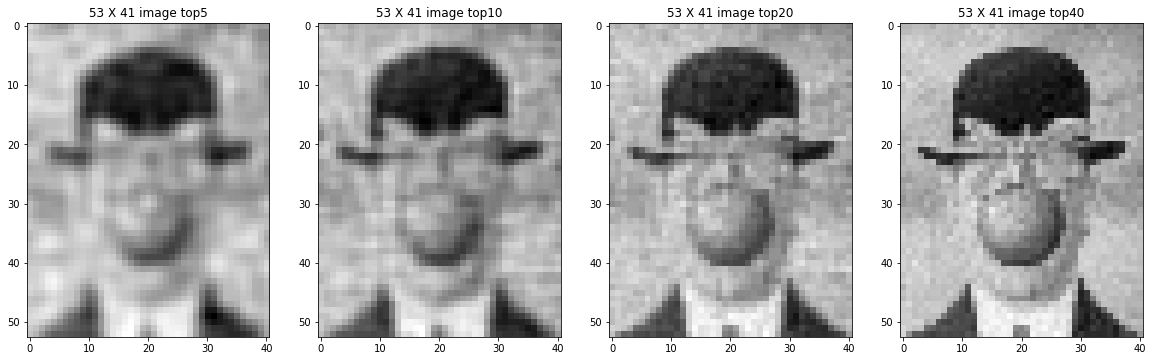

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20,10))

for i in range(len(topN)):
  ax[i].imshow(reconstructions[i], cmap = 'gray')
  ax[i].set_title("53 X 41 image "+"top"+str(topN[i]))




In [ ]:
N = vec_F.shape[0]
N

2173

In [ ]:
M = int(0.6*N)

I = np.eye(N)

I.shape

B = np.random.permutation(I)


B = B[0:M,:]


In [ ]:
y = np.dot(B,vec_F)

y.shape

(1303,)

In [ ]:
A = np.matmul(B,iD)

A.shape

(1303, 2173)

In [ ]:
x_l1 = cvx.Variable(N)


objective_l1 = cvx.Minimize( cvx.norm( x_l1, 1 ) )
constraints_l1 =  [A*x_l1 == y]
prob_l1 = cvx.Problem( objective_l1, constraints_l1)

prob_l1.solve(verbose=True, solver='CVXOPT', max_iter= 1000, reltol=1e-2, featol= 1e-2)

     pcost       dcost       gap    pres   dres   k/t
 0:  1.3375e-15 -2.0094e-15  3e+04  8e+02  6e-16  1e+00
 1:  3.2486e+01  3.2833e+01  1e+04  3e+02  3e-16  8e-01
 2:  5.1836e+01  5.2025e+01  2e+03  5e+01  2e-16  3e-01
 3:  9.5072e+01  9.5153e+01  6e+02  2e+01  4e-16  1e-01
 4:  1.3264e+02  1.3267e+02  2e+02  7e+00  6e-16  4e-02
 5:  1.5731e+02  1.5732e+02  9e+01  3e+00  6e-16  2e-02
 6:  1.6846e+02  1.6847e+02  4e+01  1e+00  7e-16  7e-03
 7:  1.7210e+02  1.7210e+02  2e+01  5e-01  7e-16  3e-03
 8:  1.7423e+02  1.7423e+02  6e+00  2e-01  8e-16  1e-03
 9:  1.7483e+02  1.7484e+02  3e+00  8e-02  8e-16  5e-04
10:  1.7515e+02  1.7515e+02  9e-01  3e-02  7e-16  2e-04
11:  1.7523e+02  1.7523e+02  5e-01  2e-02  7e-16  1e-04
12:  1.7529e+02  1.7529e+02  2e-01  5e-03  8e-16  4e-05
13:  1.7531e+02  1.7531e+02  7e-02  2e-03  7e-16  2e-05
14:  1.7532e+02  1.7532e+02  3e-02  8e-04  8e-16  6e-06
15:  1.7532e+02  1.7532e+02  1e-02  3e-04  8e-16  2e-06
16:  1.7533e+02  1.7533e+02  3e-03  9e-05  8e-16  

175.32674312794103

In [ ]:
 vec_recF = np.dot(iD,x_l1.value)



Text(0.5, 1.0, 'reconstructed image ')

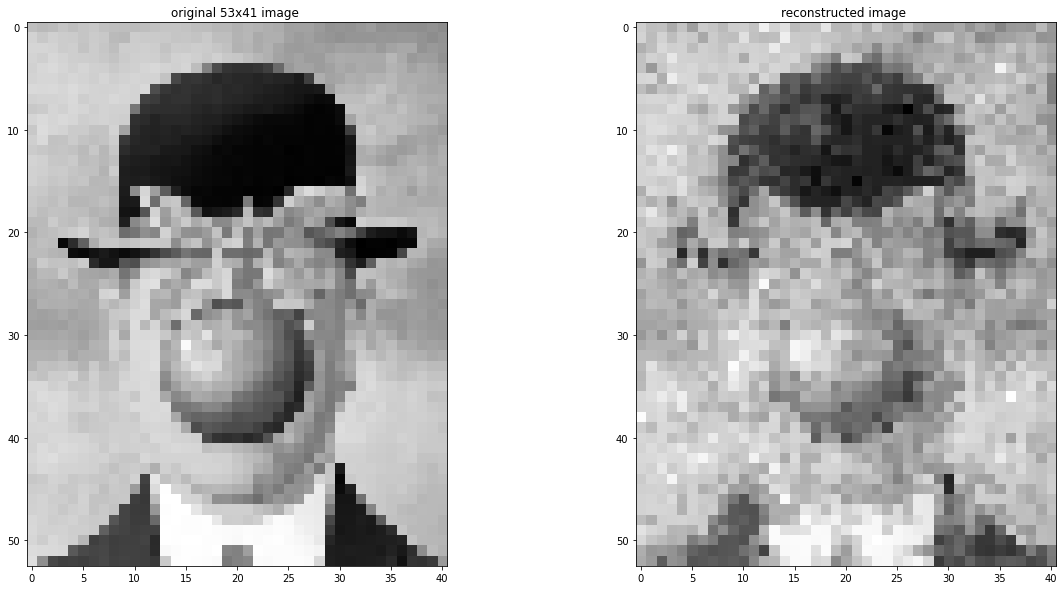

In [ ]:
reconstructed_image = vec_recF.reshape([53,41])

fig, ax = plt.subplots(1, 2, figsize=(20,10))

ax[0].imshow(img, cmap = 'gray')
ax[0].set_title("original 53x41 image ")

ax[1].imshow(reconstructed_image, cmap = 'gray')
ax[1].set_title("reconstructed image ")

In [ ]:
rec4_trial3 = vec_recF

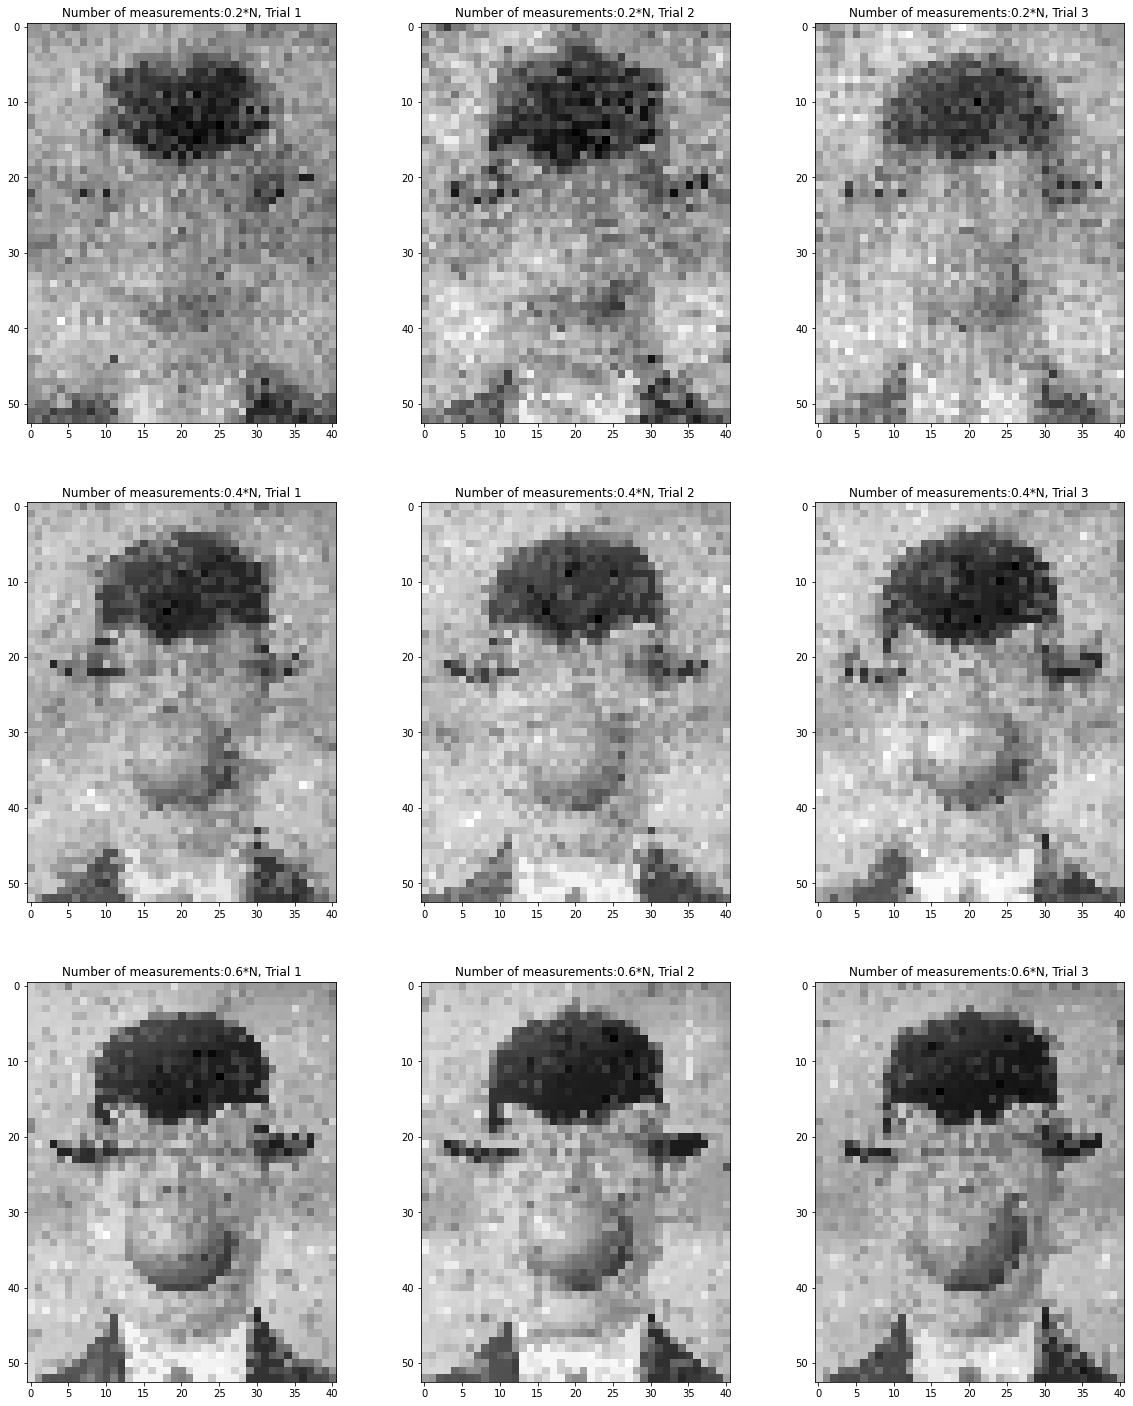

In [ ]:
reconstructed_images = []
reconstructed_images.append(rec2_trial1.reshape([53,41]))
reconstructed_images.append(rec2_trial2.reshape([53,41]))
reconstructed_images.append(rec2_trial3.reshape([53,41]))

reconstructed_images.append(rec4_trial1.reshape([53,41]))
reconstructed_images.append(rec4_trial2.reshape([53,41]))
reconstructed_images.append(rec4_trial3.reshape([53,41]))

reconstructed_images.append(rec6_trial1.reshape([53,41]))
reconstructed_images.append(rec6_trial2.reshape([53,41]))
reconstructed_images.append(rec6_trial3.reshape([53,41]))

fig, ax = plt.subplots(3, 3, figsize=(20,25))

sample_ratio = [0.2, 0.4, 0.6]

for i in range(3):
  for j in range(3):
    ax[i][j].imshow(reconstructed_images[3*i+j], cmap = 'gray')
    ax[i][j].set_title("Number of measurements:"+str(sample_ratio[i])+"*N"+ ", Trial "+str(j+1))

In [ ]:
data = np.load('/content/drive/My Drive/AMATH 582/Ass5/UnknownImage.npz')
lst = data.files

B = data[lst[0]]
y = data[lst[1]]
B.shape

D = construct_DCT_Mat(50,50)

iD = construct_iDCT_Mat(50,50)


In [ ]:
A = np.matmul(B,iD)

A.shape

(2000, 2500)

In [ ]:
x_l1 = cvx.Variable(2500)


objective_l1 = cvx.Minimize( cvx.norm( x_l1, 1 ) )
constraints_l1 =  [A*x_l1 == y]
prob_l1 = cvx.Problem( objective_l1, constraints_l1)

prob_l1.solve(verbose=True, solver='CVXOPT', max_iter= 1000, reltol=1e-2, featol= 1e-2)

     pcost       dcost       gap    pres   dres   k/t
 0:  2.9670e-14  1.9822e-14  3e+04  1e+03  1e-15  1e+00
 1:  2.9658e+01  3.0189e+01  1e+04  3e+02  3e-16  8e-01
 2:  7.2764e+01  7.2857e+01  1e+03  4e+01  3e-16  1e-01
 3:  2.0177e+02  2.0179e+02  3e+02  8e+00  6e-16  3e-02
 4:  2.8074e+02  2.8075e+02  1e+02  3e+00  1e-15  1e-02
 5:  3.0448e+02  3.0449e+02  4e+01  1e+00  1e-15  5e-03
 6:  3.1328e+02  3.1329e+02  2e+01  6e-01  1e-15  3e-03
 7:  3.1837e+02  3.1837e+02  8e+00  2e-01  1e-15  1e-03
 8:  3.2029e+02  3.2029e+02  3e+00  9e-02  1e-15  5e-04
 9:  3.2099e+02  3.2099e+02  1e+00  4e-02  1e-15  2e-04
10:  3.2129e+02  3.2129e+02  5e-01  1e-02  1e-15  9e-05
11:  3.2141e+02  3.2141e+02  2e-01  6e-03  1e-15  4e-05
12:  3.2146e+02  3.2146e+02  9e-02  2e-03  1e-15  2e-05
13:  3.2149e+02  3.2149e+02  2e-02  6e-04  1e-15  4e-06
14:  3.2149e+02  3.2149e+02  5e-03  1e-04  1e-15  1e-06
15:  3.2149e+02  3.2149e+02  1e-03  4e-05  1e-15  3e-07
16:  3.2149e+02  3.2149e+02  3e-04  9e-06  1e-15  

321.4942582359379

In [ ]:
 vec_recF = np.dot(iD,x_l1.value)

Text(0.5, 1.0, 'reconstructed image ')

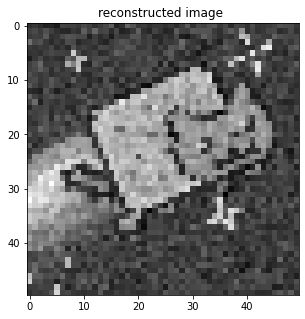

In [ ]:
reconstructed_image = vec_recF.reshape([50,50])

fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.imshow(reconstructed_image, cmap = 'gray')
ax.set_title("reconstructed image ")